Before running, make sure the requirements have been installed correctly.

In [1]:
import json

from jax import random
import jax
import jax.numpy as jnp

import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC, DiscreteHMCGibbs
from numpyro.infer.reparam import TransformReparam
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

import matplotlib.pyplot as plt

/Users/danielmanela/.virtualenvs/causal-copulas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing out performance time with high correlations

In this example we work with the following model:
$$Z~\sim~\mathcal{N}(0, 1) \\ X~|~Z~\sim~\mathcal{N}( \rho_{XZ} Z,~1 - \rho_{XZ}^{2}) \\ Y~|~\text{do}(X) \sim \mathcal{N}(X - 0.5,~1)$$
with a gaussian copula correlation of $\rho_{YZ}=\text{expit}(1)$.

## Centered vs. Non Centered Parameterisations
Sampling problems arise when dealing with highly correlated variables. In Hamiltonian Monte Carlo (HMC) and NUTS samplers, traverising across a highly correlated posterior results in either divergent transitions or very slow transition steps as transitions are generally calculated agnostic of _where_ in the posterior space they lie.

If $\rho_{XZ}$ is very close to 1 (say 0.99), by definition $X$ and $Z$ will be highly correlated and sampling will be inefficient. We can improve upon things by using a non-centered parameterisation, where we capture the same data generating setup as the centered parameterisation above. Through introducing two standard gaussian RVs $U_1, U_2$, we can do the following:

$$ Z~\sim~\mathcal{N}(0, 1) \\ \mathbf{U}~\sim~\mathcal{N}(\mathbf{0}, \mathbf{I}) \\ X~|~Z=\rho_{XZ}\cdot Z + (\sqrt{1-\rho_{XZ}^2}\cdot U_1) \\ Y~|~\text{do}(X) = X - 0.5 + U_2$$

The generating distributions are the same, but instead of sampling from highly correlated parameters, we sample from a multivariate standard Gaussian formed by $(Z,~U_1,~U_2)$.

**The function below allows you to sample from either using the** `noncentered_param` **arguement.**

#### **SPOILERS**: For some reason I'm getting divergences from the Non-centered models. Perhaps the CDF/ICDF transformations are difficult to deal with? Need to explore further.

In [13]:
num_warmup = 1000
num_samples = 10000

### Testing with constant $\rho_{YZ}$

In [14]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def high_correlations(y=None, rho=0., centered_param=True):
    Z = numpyro.sample("z", dist.Normal(0, 1))
    
    if centered_param:
        X = numpyro.sample("x", dist.Normal(rho*Z, jnp.sqrt(1 - jnp.square(rho))))
        Y = numpyro.sample("y", dist.Normal(-0.5 + X, 1))
    else:
        U1 = numpyro.sample("u1", dist.Normal(0, 1))
        U2 = numpyro.sample("u2", dist.Normal(0, 1))        
        X = numpyro.deterministic("x", rho * Z + jnp.sqrt(1 - jnp.square(rho)) * U1)
        Y = numpyro.deterministic("y", X + U2 - 0.5)
    
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(-0.5 + X, 1).cdf(Y))    
    quantiles_Z = numpyro.deterministic('q_Z', dist.Normal(0, 1).cdf(Z))
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_ZY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(1.))
    
    std_normal_Z = numpyro.deterministic('std_normal_z', dist.Normal(0, 1).icdf(quantiles_Z))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_Z, std_normal_Y, rho_ZY_val))

In [15]:
def generate_samples(model, num_warmup, num_samples, rho, centered_param=False):
    kernel = NUTS(model)
    mcmc_model = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples, 
        progress_bar=True
    )
    mcmc_model.run(
        random.PRNGKey(1),
        rho=rho,
        centered_param=centered_param
    )
    mcmc_model.print_summary()
    return mcmc_model.get_samples()

Time to test across different types of $\rho_{XZ}$:

$$\rho_{XZ} \in \{0.5, 0.9, 0.99, 0.9999\}$$

#### $\rho_{XZ} = 0.5$

In [104]:
centered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=True) 
# noncentered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=False)

sample: 100%|█| 2001000/2001000 [43:34<00:00, 765.29it/s, 7 steps of size 3.42e-



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.00      1.00      0.00     -1.63      1.67 611037.03      1.00
         y     -0.50      1.65     -0.50     -3.23      2.21 524263.02      1.00
         z      0.00      1.00      0.00     -1.65      1.65 593265.89      1.00

Number of divergences: 3


In [77]:
print(f"C Var: {jnp.var(centered_samples_rho_05['z'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_05['z'])}")

C Var: 0.9994931221008301


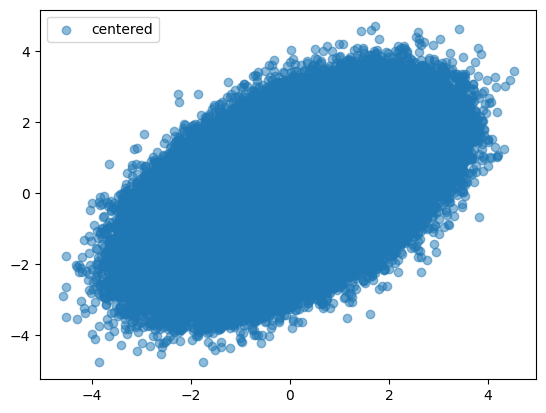

In [78]:
plt.scatter(centered_samples_rho_05['z'],centered_samples_rho_05['x'], label='centered', alpha=0.5);
# plt.scatter(noncentered_samples_rho_05['z'],noncentered_samples_rho_05['x'], label='non-centered', alpha=0.5);
plt.legend();

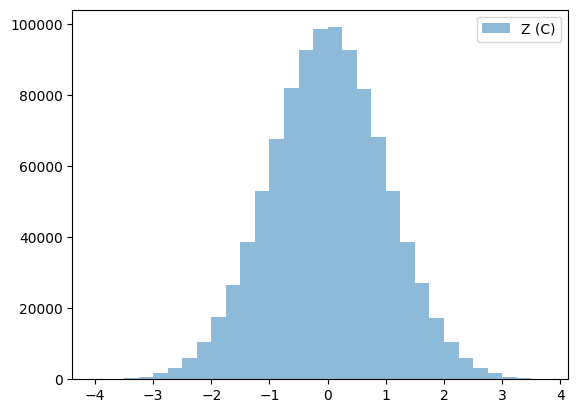

In [79]:
plt.hist(centered_samples_rho_05['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_05['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [80]:
print(f"C Var: {jnp.var(centered_samples_rho_05['x'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_05['x'])}")

C Var: 0.9994324445724487


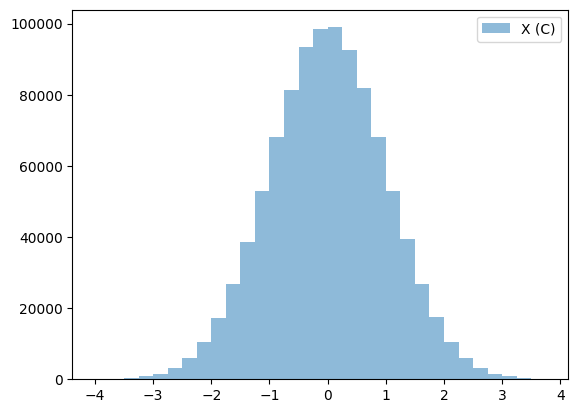

In [81]:
plt.hist(centered_samples_rho_05['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_05['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [82]:
print(f"C Var: {jnp.var(centered_samples_rho_05['y'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_05['y'])}")

C Var: 2.7287161350250244


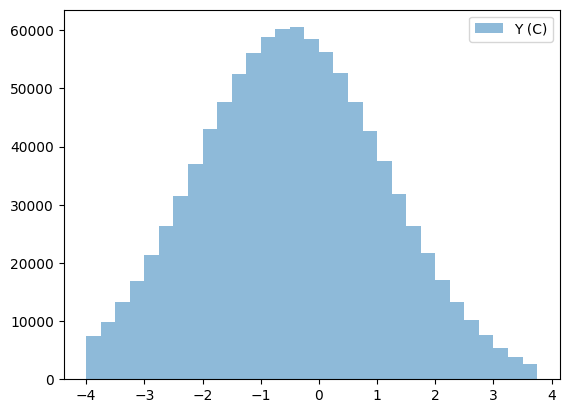

In [83]:
plt.hist(centered_samples_rho_05['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_05['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9$

In [16]:
centered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=True) 
noncentered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [00:06<00:00, 1752.08it/s, 7 steps of size 2.71e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.01      1.01      0.01     -1.74      1.58   1950.73      1.00
         y     -0.53      1.84     -0.51     -3.24      2.80   1941.28      1.00
         z     -0.00      1.01      0.01     -1.65      1.66   1970.16      1.00

Number of divergences: 0


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [00:06<00:00, 1769.50it/s, 7 steps of size 6.65e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.00      0.99      0.02     -1.63      1.59   6936.50      1.00
        u2      0.01      1.00      0.01     -1.65      1.64   5511.91      1.00
         z      0.01      1.00      0.00     -1.62      1.69   5327.22      1.00

Number of divergences: 0


In [85]:
print(f"C Var: {jnp.var(centered_samples_rho_09['z'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_09['z'])}")

C Var: 0.9988609552383423


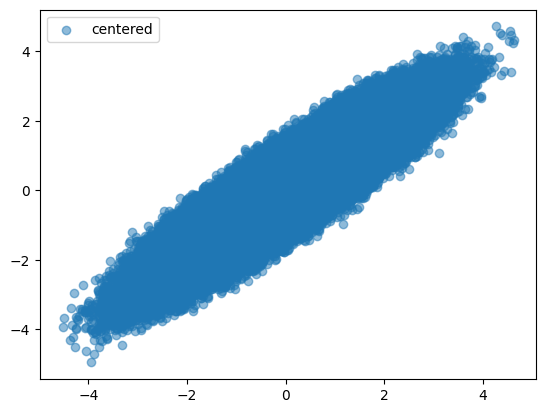

In [86]:
plt.scatter(centered_samples_rho_09['z'],centered_samples_rho_09['x'], label='centered', alpha=0.5);
# plt.scatter(noncentered_samples_rho_09['z'],noncentered_samples_rho_09['x'], label='non-centered', alpha=0.5);
plt.legend()

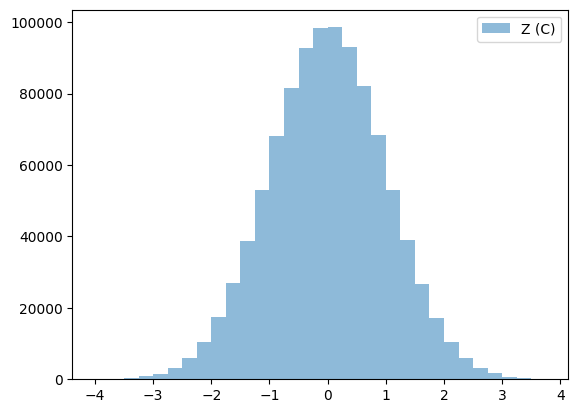

In [87]:
plt.hist(centered_samples_rho_09['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_09['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [88]:
print(f"C Var: {jnp.var(centered_samples_rho_09['x'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_09['x'])}")

C Var: 0.9995664954185486


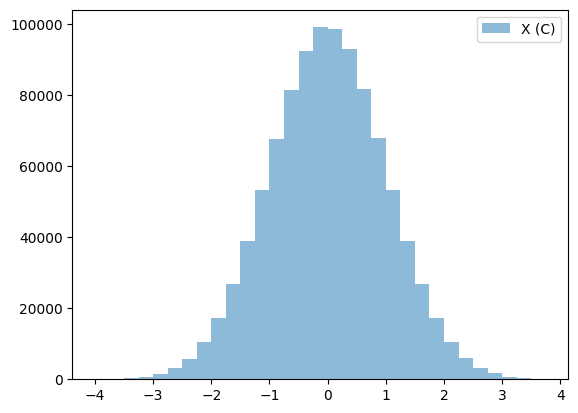

In [89]:
plt.hist(centered_samples_rho_09['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_09['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [90]:
print(f"C Var: {jnp.var(centered_samples_rho_09['y'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_09['y'])}")

C Var: 3.315134286880493


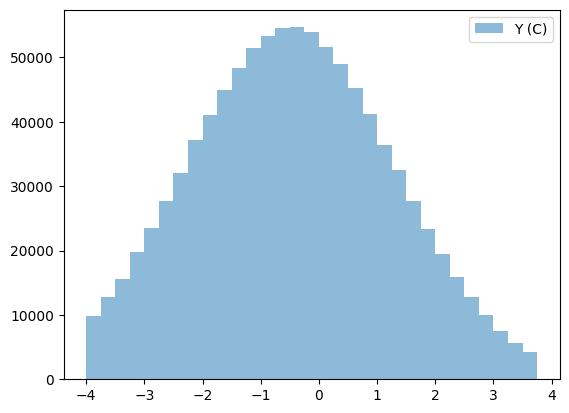

In [91]:
plt.hist(centered_samples_rho_09['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_09['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.99$

In [ ]:
centered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=True) 
# noncentered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=False)

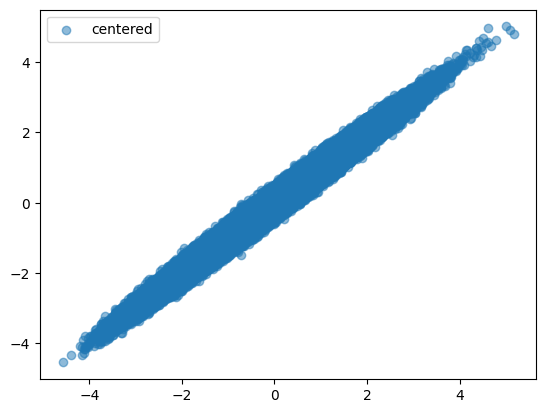

In [93]:
plt.scatter(centered_samples_rho_099['z'],centered_samples_rho_099['x'], label='centered', alpha=0.5);
# plt.scatter(noncentered_samples_rho_099['z'],noncentered_samples_rho_099['x'], label='non-centered', alpha=0.5);
plt.legend()

In [94]:
print(f"C Var: {jnp.var(centered_samples_rho_099['z'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_099['z'])}")

C Var: 0.9971615672111511


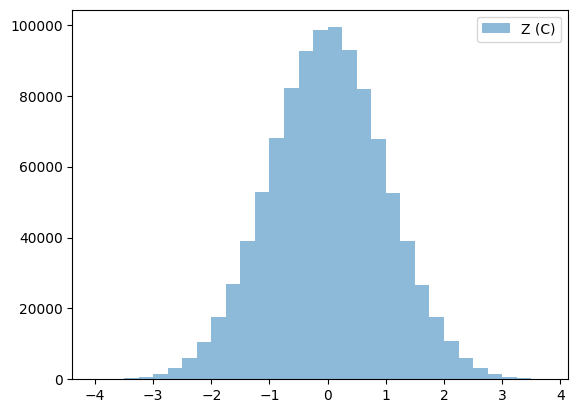

In [95]:
plt.hist(centered_samples_rho_099['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_099['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [96]:
print(f"C Var: {jnp.var(centered_samples_rho_099['x'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_099['x'])}")

C Var: 0.9972608685493469


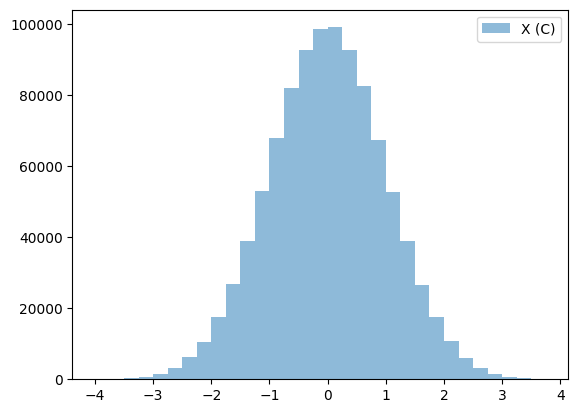

In [97]:
plt.hist(centered_samples_rho_099['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_099['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [98]:
print(f"C Var: {jnp.var(centered_samples_rho_099['y'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_099['y'])}")

C Var: 3.440019369125366


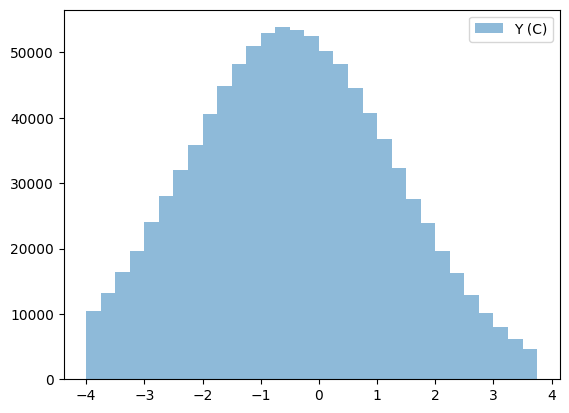

In [99]:
plt.hist(centered_samples_rho_099['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_099['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9999$

In [29]:
centered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=True) 
# noncentered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=False)

sample: 100%|█| 501000/501000 [08:20<00:00, 1001.25it/s, 255 steps of size 8.47e



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.00      1.00     -0.01     -1.67      1.61  55240.24      1.00
         y     -0.51      1.86     -0.50     -3.56      2.55  57513.61      1.00
         z     -0.00      1.00     -0.01     -1.66      1.62  55227.95      1.00

Number of divergences: 0


sample: 100%|█| 501000/501000 [08:36<00:00, 970.32it/s, 3 steps of size 5.47e-01



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.00      1.00     -0.00     -1.65      1.63 342932.57      1.00
        u2     -0.00      1.00      0.00     -1.63      1.65 266354.50      1.00
         z     -0.00      1.00     -0.00     -1.66      1.63 259446.94      1.00

Number of divergences: 0


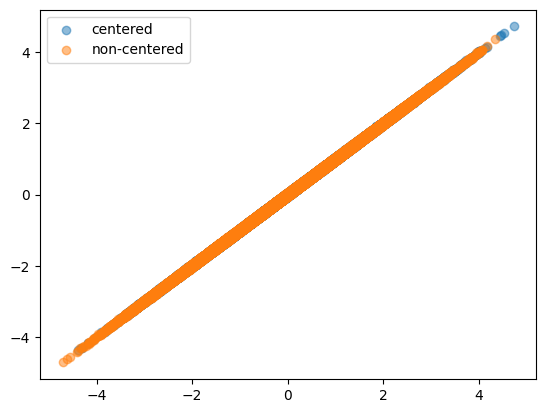

In [30]:
plt.scatter(centered_samples_rho_09999['z'],centered_samples_rho_09999['x'], label='centered', alpha=0.5);
# plt.scatter(noncentered_samples_rho_09999['z'],noncentered_samples_rho_09999['x'], label='non-centered', alpha=0.5);
plt.legend();

In [31]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['z'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['z'])}")

C Var: 0.9919736385345459
NC Var: 0.9972178339958191


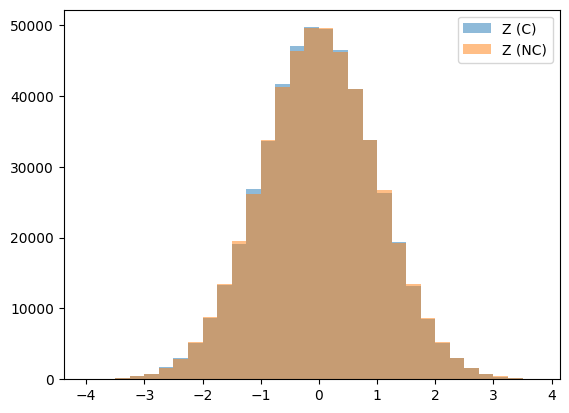

In [32]:
plt.hist(centered_samples_rho_09999['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_09999['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [33]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['x'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['x'])}")

C Var: 0.9919445514678955
NC Var: 0.9972370266914368


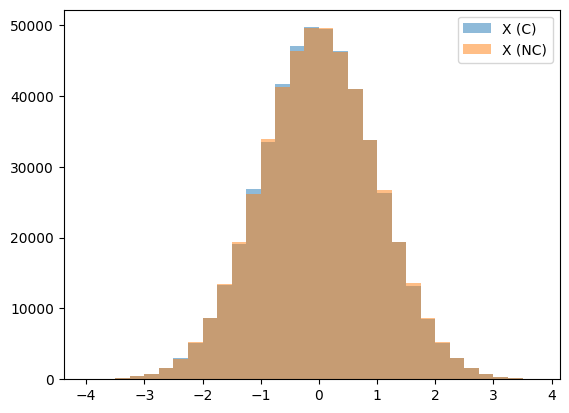

In [34]:
plt.hist(centered_samples_rho_09999['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_09999['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [35]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['y'])}")
# print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['y'])}")

C Var: 3.445002555847168
NC Var: 3.449251413345337


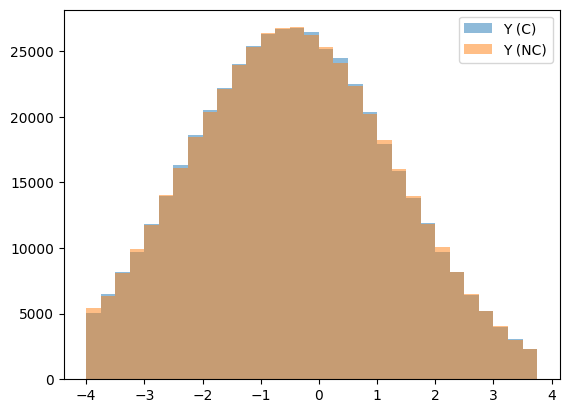

In [36]:
plt.hist(centered_samples_rho_09999['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
# plt.hist(noncentered_samples_rho_09999['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [ ]:
pd.DataFrame(centered_samples_rho_05)[['x', 'y', 'z']].to_csv('constant_copula_samples_rho_05.csv', index=False)
pd.DataFrame(centered_samples_rho_09)[['x', 'y', 'z']].to_csv('constant_copula_samples_rho_09.csv', index=False)
pd.DataFrame(centered_samples_rho_099)[['x', 'y', 'z']].to_csv('constant_copula_samples_rho_099.csv', index=False)

### Testing with $\rho_{YZ} | X = \text{expit}(X)$

In [38]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def high_correlations(y=None, rho=0., centered_param=True):
    Z = numpyro.sample("z", dist.Normal(0, 1))
    
    if centered_param:
        X = numpyro.sample("x", dist.Normal(rho*Z, jnp.sqrt(1 - jnp.square(rho))))
        Y = numpyro.sample("y", dist.Normal(-0.5 + X, 1))
    else:
        U1 = numpyro.sample("u1", dist.Normal(0, 1))
        U2 = numpyro.sample("u2", dist.Normal(0, 1))        
        X = numpyro.deterministic("x", rho * Z + jnp.sqrt(1 - jnp.square(rho)) * U1)
        Y = numpyro.deterministic("y", X + U2 - 0.5)
    
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(-0.5 + X, 1).cdf(Y))    
    quantiles_Z = numpyro.deterministic('q_Z', dist.Normal(0, 1).cdf(Z))
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_ZY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(X))
    
    std_normal_Z = numpyro.deterministic('std_normal_z', dist.Normal(0, 1).icdf(quantiles_Z))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_Z, std_normal_Y, rho_ZY_val))

In [39]:
def generate_samples(model, num_warmup, num_samples, rho, centered_param=False):
    kernel = NUTS(model)
    mcmc_model = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples, 
        progress_bar=True
    )
    mcmc_model.run(
        random.PRNGKey(1),
        rho=rho,
        centered_param=centered_param
    )
    mcmc_model.print_summary()
    return mcmc_model.get_samples()

Time to test across different types of $\rho_{XZ}$:

$$\rho_{XZ} \in \{0.5, 0.9, 0.99, 0.9999\}$$

#### $\rho_{XZ} = 0.5$

In [40]:
centered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=True) 
noncentered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=False)

sample: 100%|█| 501000/501000 [09:25<00:00, 886.12it/s, 15 steps of size 5.04e-0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.07      0.96     -0.06     -1.67      1.49 133208.52      1.00
         y     -0.49      1.53     -0.52     -2.99      2.04 126666.81      1.00
         z     -0.03      0.99     -0.03     -1.67      1.58 159736.59      1.00

Number of divergences: 11194


sample: 100%|█| 501000/501000 [09:16<00:00, 900.71it/s, 5 steps of size 5.65e-01



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1     -0.06      0.97     -0.06     -1.65      1.54 300650.55      1.00
        u2      0.08      1.00      0.08     -1.58      1.70 296368.99      1.00
         z     -0.03      0.99     -0.03     -1.64      1.61 281116.24      1.00

Number of divergences: 567


In [41]:
print(f"C Var: {jnp.var(centered_samples_rho_05['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['z'])}")

C Var: 0.9779639840126038
NC Var: 0.9775943756103516


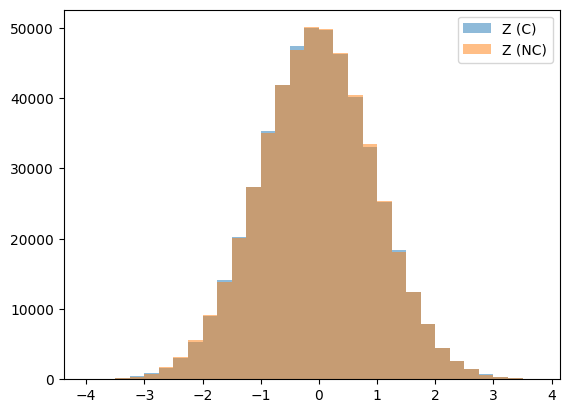

In [42]:
plt.hist(centered_samples_rho_05['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [43]:
print(f"C Var: {jnp.var(centered_samples_rho_05['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['x'])}")

C Var: 0.9247080087661743
NC Var: 0.925970733165741


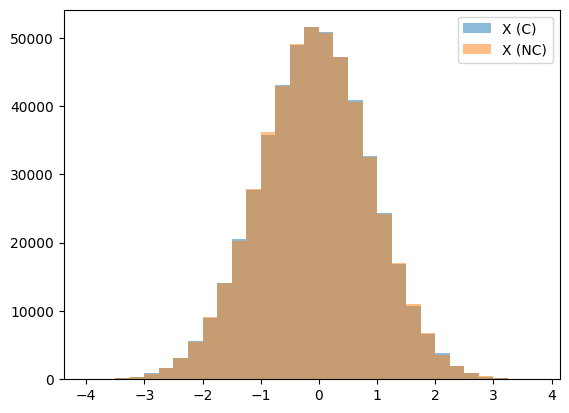

In [44]:
plt.hist(centered_samples_rho_05['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [45]:
print(f"C Var: {jnp.var(centered_samples_rho_05['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['y'])}")

C Var: 2.3506712913513184
NC Var: 2.352940082550049


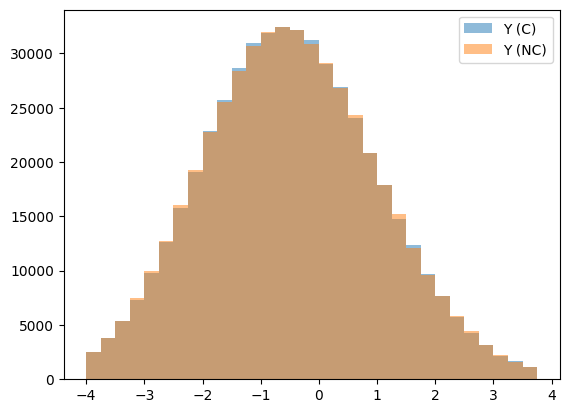

In [46]:
plt.hist(centered_samples_rho_05['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9$

In [47]:
centered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=True) 
noncentered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=False)

sample: 100%|█| 501000/501000 [09:37<00:00, 867.66it/s, 15 steps of size 2.73e-0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.07      0.96     -0.06     -1.65      1.52  99639.38      1.00
         y     -0.42      1.64     -0.48     -3.10      2.28 105377.64      1.00
         z     -0.06      0.97     -0.05     -1.66      1.53 100639.44      1.00

Number of divergences: 251


sample: 100%|█| 501000/501000 [07:35<00:00, 1100.45it/s, 7 steps of size 5.89e-0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1     -0.03      0.99     -0.03     -1.68      1.59 328344.61      1.00
        u2      0.15      0.99      0.15     -1.48      1.79 268990.34      1.00
         z     -0.06      0.97     -0.06     -1.65      1.55 235083.11      1.00

Number of divergences: 1465


In [48]:
print(f"C Var: {jnp.var(centered_samples_rho_09['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['z'])}")

C Var: 0.9414675235748291
NC Var: 0.9463379979133606


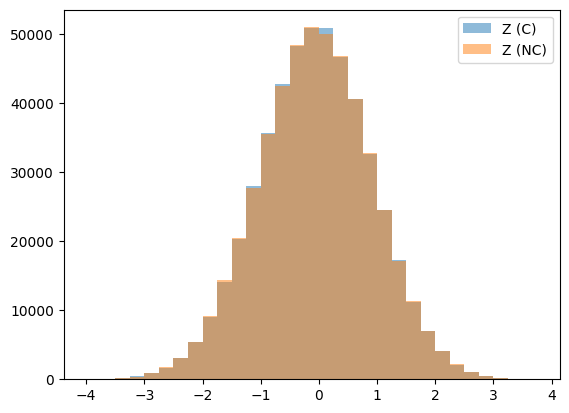

In [49]:
plt.hist(centered_samples_rho_09['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [50]:
print(f"C Var: {jnp.var(centered_samples_rho_09['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['x'])}")

C Var: 0.9279986023902893
NC Var: 0.9329584240913391


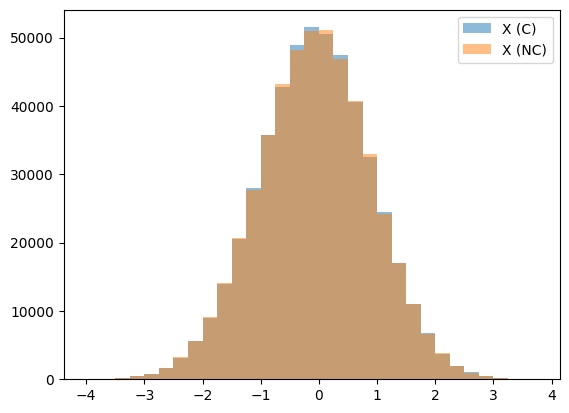

In [51]:
plt.hist(centered_samples_rho_09['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [52]:
print(f"C Var: {jnp.var(centered_samples_rho_09['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['y'])}")

C Var: 2.699812412261963
NC Var: 2.706672430038452


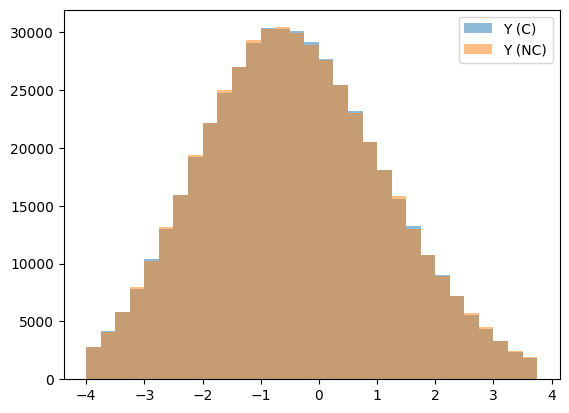

In [53]:
plt.hist(centered_samples_rho_09['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.99$

In [54]:
centered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=True) 
noncentered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=False)

sample: 100%|█| 501000/501000 [09:17<00:00, 898.59it/s, 31 steps of size 9.62e-0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.07      0.96     -0.06     -1.66      1.51  79658.53      1.00
         y     -0.41      1.66     -0.49     -3.15      2.30  86106.48      1.00
         z     -0.07      0.96     -0.06     -1.66      1.51  79791.21      1.00

Number of divergences: 0


sample: 100%|█| 501000/501000 [08:45<00:00, 953.78it/s, 7 steps of size 5.91e-01



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1     -0.01      1.00     -0.01     -1.67      1.61 347962.76      1.00
        u2      0.16      0.99      0.17     -1.48      1.79 253212.01      1.00
         z     -0.07      0.96     -0.06     -1.67      1.51 231562.14      1.00

Number of divergences: 1295


In [55]:
print(f"C Var: {jnp.var(centered_samples_rho_099['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['z'])}")

C Var: 0.9302948713302612
NC Var: 0.9302707314491272


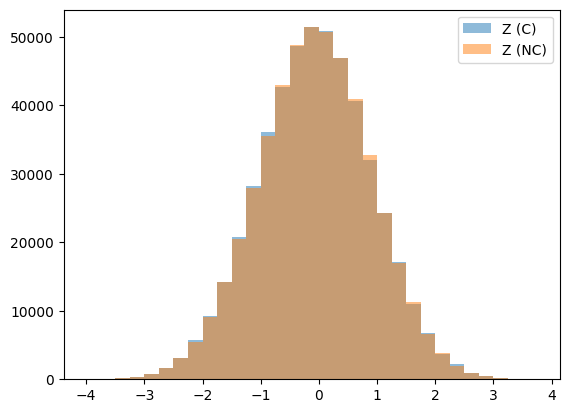

In [56]:
plt.hist(centered_samples_rho_099['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [57]:
print(f"C Var: {jnp.var(centered_samples_rho_099['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['x'])}")

C Var: 0.9289077520370483
NC Var: 0.9292406439781189


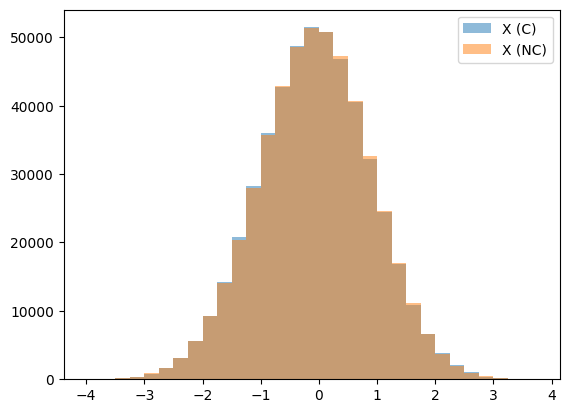

In [58]:
plt.hist(centered_samples_rho_099['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [59]:
print(f"C Var: {jnp.var(centered_samples_rho_099['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['y'])}")

C Var: 2.7715110778808594
NC Var: 2.7773215770721436


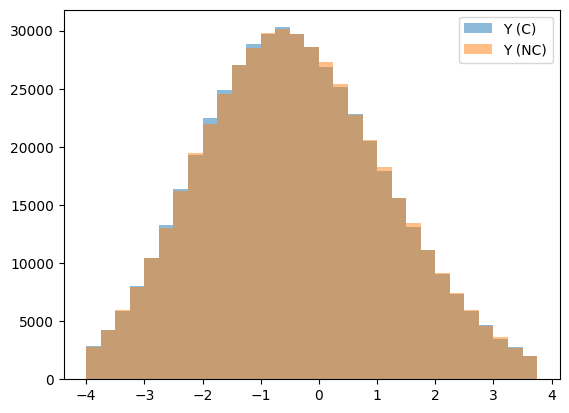

In [60]:
plt.hist(centered_samples_rho_099['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9999$

In [61]:
centered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=True) 
noncentered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=False)

sample: 100%|█| 501000/501000 [09:52<00:00, 845.83it/s, 255 steps of size 9.79e-



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.07      0.96     -0.06     -1.67      1.49  59429.41      1.00
         y     -0.41      1.66     -0.48     -3.13      2.31  64278.86      1.00
         z     -0.07      0.96     -0.06     -1.65      1.51  59429.74      1.00

Number of divergences: 0


sample: 100%|█| 501000/501000 [08:29<00:00, 983.40it/s, 7 steps of size 5.76e-01



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1     -0.00      1.00     -0.00     -1.64      1.64 352254.11      1.00
        u2      0.16      0.99      0.17     -1.46      1.80 272200.36      1.00
         z     -0.07      0.96     -0.06     -1.64      1.53 232117.63      1.00

Number of divergences: 1079


In [62]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['z'])}")

C Var: 0.9224598407745361
NC Var: 0.9238856434822083


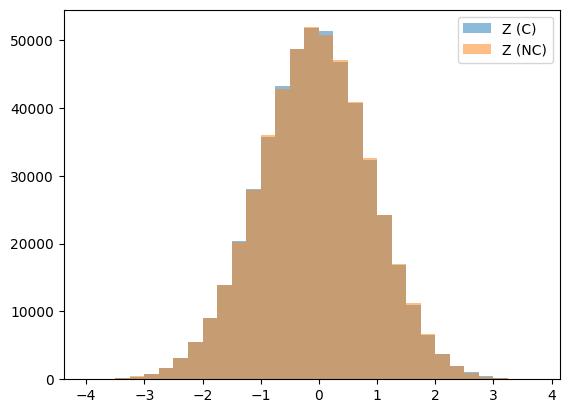

In [63]:
plt.hist(centered_samples_rho_09999['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [64]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['x'])}")

C Var: 0.9224567413330078
NC Var: 0.9239212274551392


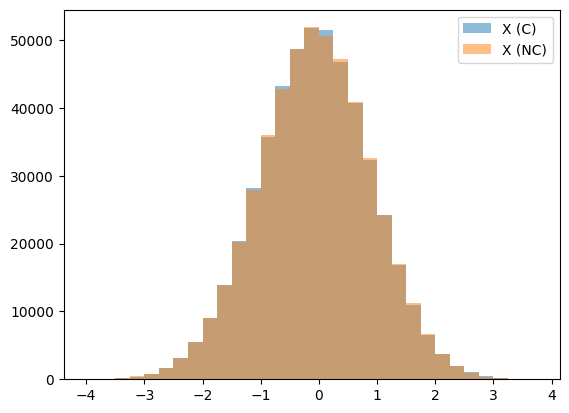

In [65]:
plt.hist(centered_samples_rho_09999['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [66]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['y'])}")

C Var: 2.7686545848846436
NC Var: 2.772566318511963


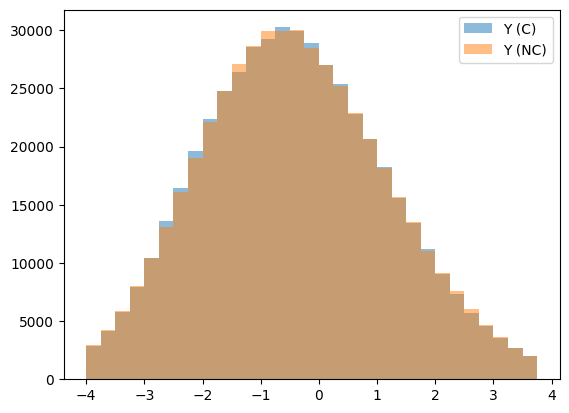

In [67]:
plt.hist(centered_samples_rho_09999['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

## Regression is a pain in python, saving and reading using R

In [68]:
pd.DataFrame(centered_samples_rho_05)[['x', 'y', 'z']].to_csv('variable_copula_samples_rho_05.csv', index=False)
pd.DataFrame(centered_samples_rho_099)[['x', 'y', 'z']].to_csv('variable_copula_samples_rho_09.csv', index=False)
pd.DataFrame(centered_samples_rho_099)[['x', 'y', 'z']].to_csv('variable_copula_samples_rho_099.csv', index=False)